<a href="https://colab.research.google.com/github/graumannm/Berlin_Bike_CV/blob/main/s03_kmedoids_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# define model and dataset names, path and number of clusters
model_name = 'dinoS14'
dataset = 'bikelanes'
data_dir  = '/gdrive/My Drive/berlin_bike_CV/final_project_first_images/labelled images/'
k = 2 # number of clusters

## Setup

In [37]:
# we install scikit-learn-extra to get k-medoids
!pip install scikit-learn-extra

In [38]:
from google.colab import drive
import pickle
import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import skimage.io as io
from numpy import dot
from numpy.linalg import norm

In [39]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [40]:
# load pickled features from gdrive

# Path to the pickle file
file_path = data_dir + model_name + '_' + dataset + "_embeddings.pickle"

# Load the dictionary from the pickle file
with open(file_path, "rb") as myfile:
    img_embedding_dict = pickle.load(myfile)

In [41]:
# sort data for convenience
X = []
images = []

for image, embedding in img_embedding_dict.items():

    X.append(embedding) # embedding matrix
    images.append(image) # file names

## Run clustering

In [42]:
# instantiate class & run clustering
kmedoids = KMedoids(n_clusters=k, random_state=0, init='k-medoids++', metric='cosine').fit(X)

In [43]:
# assignment of file names to different clusters
image_clusters = dict(zip(images, kmedoids.labels_))

# sort by values (they are 0 and 1) to check what it does
sorted_clusters = sorted(image_clusters.items(), key=lambda x:x[1])

# how many images were assigned to which label
clusters, counts = np.unique(kmedoids.labels_, return_counts=True)

cluster_counts = sorted(list(zip(clusters, counts)), key=lambda x:x[-1], reverse=True)
cluster_counts = dict(cluster_counts)
print('Number of images assigned per cluster: ', cluster_counts)

Number of images assigned per cluster:  {0: 129, 1: 113}


## Extract medoid (data point at cluster center)

In [44]:
# For each cluster, get the medoid (cluster center). This is also the most
# representative image of each cluster

representative_images = []
representative_embeddings = []
cluster_number_i = []
cluster_dict = {}

# loop through all images
for image, embedding in img_embedding_dict.items():
    # image: file name
    # embedding: embedding

    # loop through k medoids
    for cluster_number, i_embedding in enumerate(kmedoids.cluster_centers_):
      # kmedoids.cluster_centers_ is n clusters X features (e.g. 512), contains
      # center features of each cluster
      # so contains one feature vector per k
      # cluster_number: cluster label: 0 or 1 for k=2

      comparison = np.equal(i_embedding, embedding) # compare central cluster vs current image
        # comparison returns True if features are same at a given position in feature vector

      if comparison.all(): # if all features are equal to central cluster
          print('medoid is ' + image)
          representative_images.append(image) # save file name
          representative_embeddings.append(embedding) # save 512x1 embeddings in nested list
          cluster_number_i.append(image_clusters[image]) # save cluster label per representative feature
          cluster_dict[image_clusters[image]] = image # make dictionary with key=cluster number value=filename

medoid is bikelane_1161429684681057.jpg
medoid is bikelane_1079039869166855.jpg


## Explore what visual features the clusters are sorted by

In [45]:
# load dict with file name as key and full path as value
file_path = data_dir + model_name + '_' + dataset +"_paths.pickle"

# Open the file in read binary mode
with open(file_path, 'rb') as file:
    # Load the dictionary from the file
    full_img_paths = pickle.load(file)

### Plot medoids

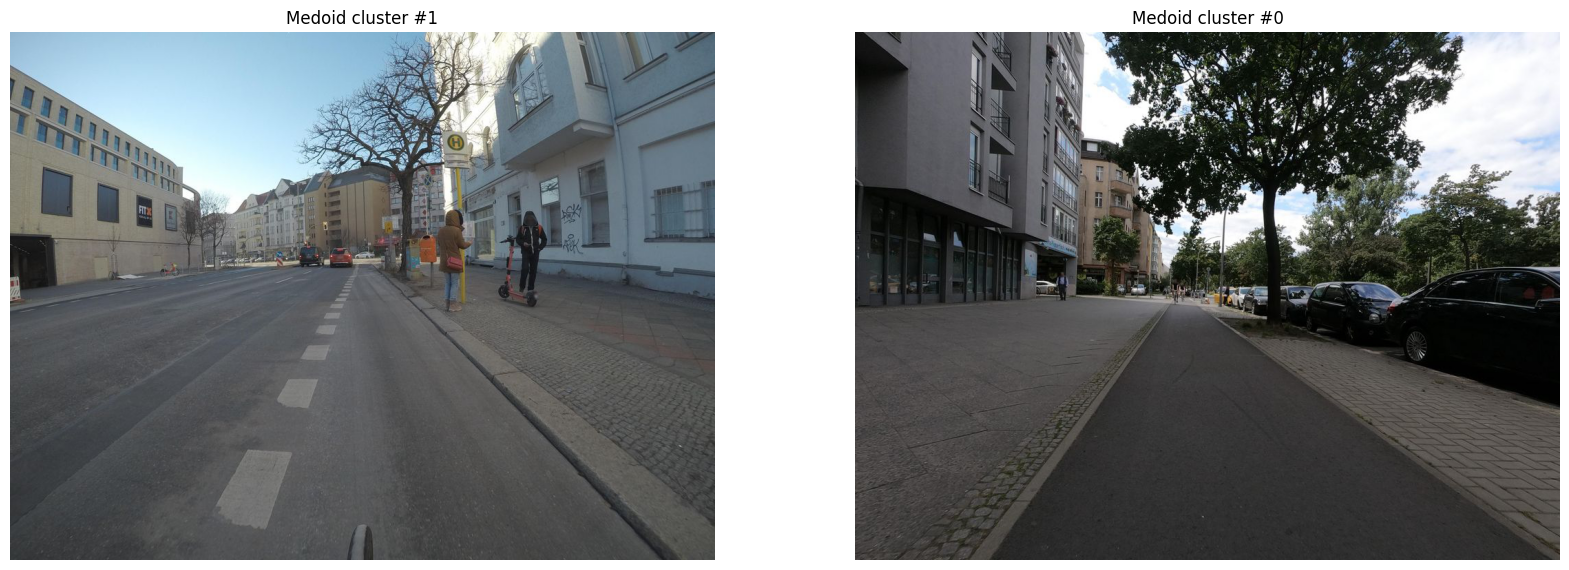

In [46]:
# plot medoids/most representative image per cluster
f, axarr = plt.subplots(1, k, figsize=(20, 20))

for i in range(k):
  axarr[i].imshow(io.imread(full_img_paths[representative_images[i]]))
  axarr[i].axis('off')
  axarr[i].set_title('Medoid cluster #' + str(image_clusters[representative_images[i]]))

### Plot medoid and its 8 closest neighbours

In [47]:
# define cosine similarity function
def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))

In [48]:
# compute cosine similarity of medoid to all other image embeddings in cluster

# pre-allocate dictionary for each cluster
cos2medoid = []
for i in range(k):
  cos2medoid.append({})

for fname, c in image_clusters.items():

  # get medoid of cluster c
  medoid_fname = cluster_dict[c]
  medoid = img_embedding_dict[medoid_fname]

  # compute cosine similarity of this image to its cluster's medoid and save
  # with filename of compared img
  cos2medoid[c][fname] = cosine_similarity(medoid, img_embedding_dict[fname])

# sort dictionaries based on similarities
sorted_cos2medoid = [dict(), dict()]

sorted_cos2medoid = [[] for _ in range(k)]
for ic, dic in enumerate(cos2medoid):
  sorted_cos2medoid[ic] = sorted(cos2medoid[ic].items(), key=lambda x:x[1], reverse=True)

In [52]:
# plot medoid and 8 closest neighbours
def plot_nearest_cosine_neighbors(icluster):

  n_plots = 8
  rows = 2
  columns = 4
  counter = 0

  f, axarr = plt.subplots(rows,columns, figsize=(15,7))

  for r in range(rows):
   for col in range(columns):

      # get filename of cluster icluster
      my_file = sorted_cos2medoid[icluster][counter][0]
      my_cosine = sorted_cos2medoid[icluster][counter][1]

      axarr[r][col].imshow(io.imread(full_img_paths[my_file]))
      #axarr[r][col].set_title(sorted_cos2medoid[icluster][counter][1])
      my_title = 'cosine similarity: {0:.3f}'.format(sorted_cos2medoid[icluster][counter][1])
      axarr[r][col].set_title(my_title)
      axarr[r][col].axis('off')
      counter += 1

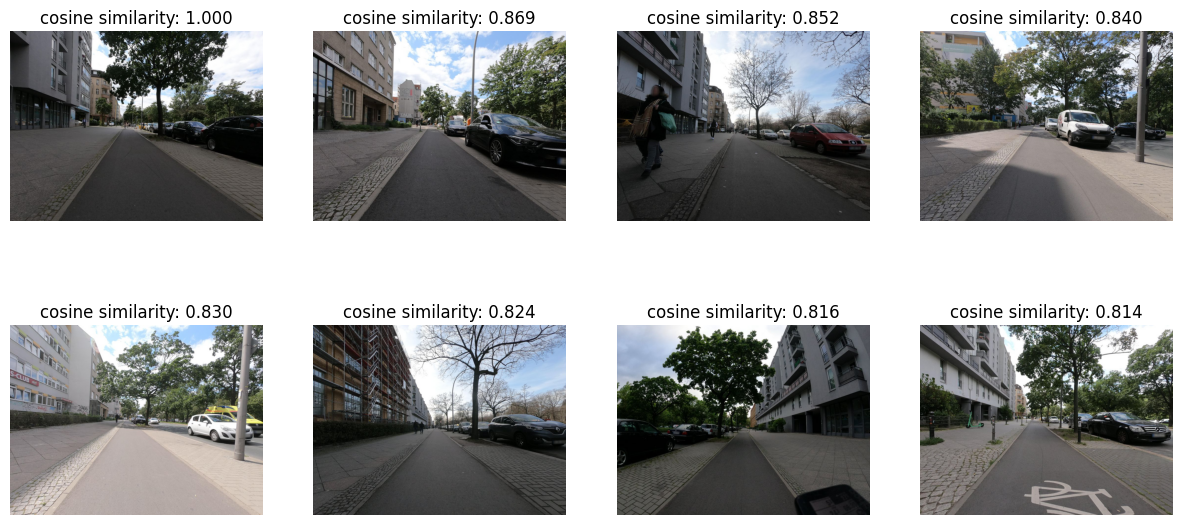

In [53]:
# slider_value: max is k

slider_value = 0  #@param {type: "slider", min: 0, max: 1}
plot_nearest_cosine_neighbors(slider_value)

## Save medoids for soft label inference of new images

In [51]:
# cluster 0 is off the street ('unsafe'), cluster 1 is on the street ('safe')

# make dictionary with hand-label as key and image file name as value
medoid_fname = {}
medoid_fname['street_shared'] = cluster_dict[1]
medoid_fname['off_street'] = cluster_dict[0]

# make dictionary with hand-label as key and medoid embedding as value
medoid_features = {}
medoid_features['street_shared'] = img_embedding_dict[medoid_fname['street_shared']]
medoid_features['off_street'] = img_embedding_dict[medoid_fname['off_street']]

# put them in a list to save
medoids = [medoid_fname, medoid_features]

file_path = data_dir + model_name + '_' + dataset + "_medoids.pickle"

# Save the dictionary as a pickle file
with open(file_path, "wb") as file:
    pickle.dump(medoids, file)

# also save the cluster assignment vector for visualization
file_path = data_dir + model_name + '_' + dataset + "_cluster_assignment.pickle"

# Save the dictionary as a pickle file
with open(file_path, "wb") as file:
    pickle.dump(kmedoids.labels_, file)